# Data exploration

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.wkb 
import requests
import matplotlib.pyplot as plt

## Utils
**df_from_carto**

In [2]:
def df_from_carto(account, query):
    """
    It gets data by querying a carto table and converts it into a GeoDataFrame.
    """
    urlCarto = f"https://{account}.carto.com/api/v2/sql"
    
    sql = {"q": query}
    r = requests.get(urlCarto, params=sql)
    
    data = r.json()
    
    df = gpd.GeoDataFrame(data.get("rows"))
    if 'the_geom' in df.columns:
        # Change geometry from WKB to WKT format
        df['geometry'] = df.apply(lambda x: shapely.wkb.loads(x['the_geom'],hex=True), axis=1 )
        df.drop(columns='the_geom', inplace=True)
        if 'the_geom_webmercator' in df.columns:
            df.drop(columns=['the_geom_webmercator'], inplace=True)
        df.crs = {'init': 'epsg:4326'}
        df = df.to_crs({'init': 'epsg:4326'})
        
    return df

## Read data

**China provices**

In [3]:
account = "wri-rw"

query = "SELECT * FROM gadm36_1 where gid_0='CHN'"

china = df_from_carto(account, query)

/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


**Coal plants**

In [58]:
# Readme
readme = pd.read_excel('../data/煤电财务数据说明_financial data for coal power plants 20201104.xlsx', sheet_name='Readme')

# Chinese English names and other
info = pd.read_excel('../data/煤电财务数据说明_financial data for coal power plants 20201104.xlsx', sheet_name='Chinese_English_names and other')
info.rename(columns={'chinese_name': 'chinese name'}, inplace=True)
info.drop_duplicates(subset=['chinese name', 'plant', 'capacity'], inplace=True)

# New plants
new_plants = pd.read_excel('../data/煤电财务数据说明_financial data for coal power plants 20201104.xlsx', sheet_name='Plant_New')
new_plants.columns = map(str.lower, new_plants.columns)
new_plants.rename(columns={'province_chinese': 'province', 'capacity': 'capacity (mw)'}, inplace=True)
new_plants['status'] = 'new'

# Operating plants
operating_plants = pd.read_excel('../data/煤电财务数据说明_financial data for coal power plants 20201104.xlsx', sheet_name='Plant_Operating')
operating_plants.columns = map(str.lower, operating_plants.columns)
operating_plants['status'] = 'operating'
operating_plants = operating_plants[list(new_plants.columns)+['age']]

# Plants
plants = pd.concat([new_plants, operating_plants])
plants.drop_duplicates(subset=list(new_plants.columns), inplace=True)
plants = gpd.GeoDataFrame(plants, geometry=gpd.points_from_xy(plants.longitude, plants.latitude))

In [5]:
plants

,country,province,chinese name,capacity (mw),status,year,latitude,longitude,combustion technology,plant,age,geometry
0,China,内蒙古,赤峰经济开发区自备热电联产项目,350,new,2018.0,42.273670,119.144200,Supercritical,Chifeng Economic Development Zone Captive Coge...,NaN,POINT (119.14420 42.27367)
2,China,广东,华电韶关南雄上大压小热电联产,350,new,2018.0,25.146160,114.290600,Supercritical,Huadian Nanxiong power station,NaN,POINT (114.29060 25.14616)
3,China,山西,同煤阳高热电公司,350,new,2018.0,40.263630,113.650800,Supercritical,Yanggao power station,NaN,POINT (113.65080 40.26363)
4,China,河北,华润电力沧州运东公司,350,new,2019.0,38.328810,117.068500,Supercritical,Cangzhou Yundong Cogen power station,NaN,POINT (117.06850 38.32881)
6,China,河北,华润电力唐山曹妃甸公司二期,1000,new,2019.0,38.996070,118.487500,Ultra-super,China Resources Caofeidian power station,NaN,POINT (118.48750 38.99607)
...,...,...,...,...,...,...,...,...,...,...,...,...
2402,China,浙江,浙能温州发电公司四期,660,operating,2015.0,27.995710,120.835858,Ultra-super,Zheneng Wenzhou power station,5.0,POINT (120.83586 27.99571)
2404,China,浙江,浙能乐清发电公司,600,operating,2008.0,28.170407,121.088938,Supercritical,Zheneng Yueqing power station,12.0,POINT (121.08894 28.17041)
2406,China,浙江,浙能乐清发电公司,660,operating,2010.0,28.170407,121.088938,Ultra-super,Zheneng Yueqing power station,10.0,POINT (121.08894 28.17041)
2408,China,浙江,中石化镇海炼化发电厂,50,operating,2003.0,29.976812,121.687953,Unknown,Zhenhai Oil power station,17.0,POINT (121.68795 29.97681)


**Coal map**

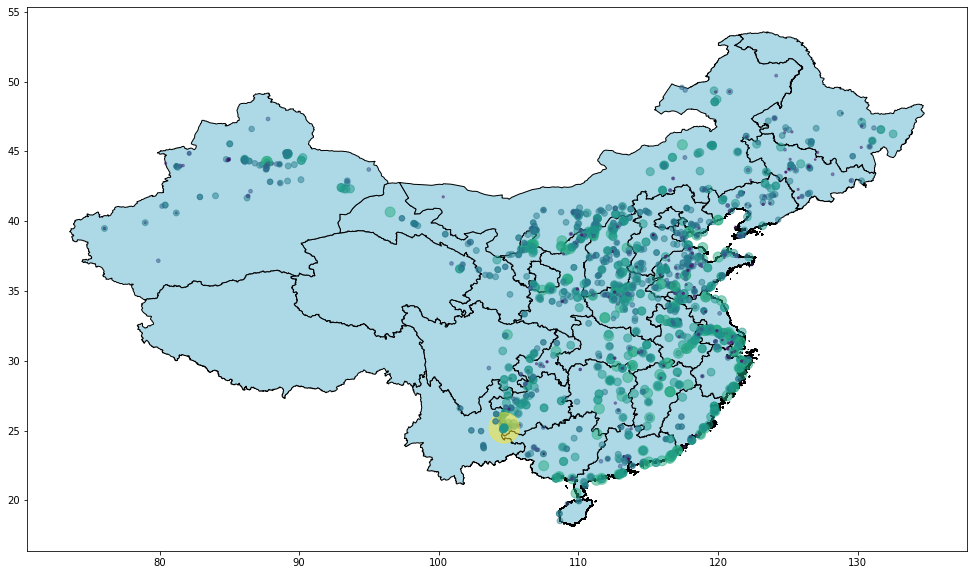

In [6]:
fig, ax = plt.subplots(figsize=(20,10))
china.plot(ax=ax,color='lightblue',edgecolor='k')
plants.plot(ax=ax,c=np.log(plants['capacity (mw)']), markersize=plants['capacity (mw)']*1e-1, alpha=0.5)

**Scenarios**
- Variables
    - **[IRR](https://en.wikipedia.org/wiki/Internal_rate_of_return)**: Internal Rate of Return (%)
    - **[LCOE](https://en.wikipedia.org/wiki/Levelized_cost_of_energy)**: Levelized Cost of Energy (Yuan/kwh)
- Scenarios:
    - **BAU**: Baseline scenario: The life span of the unit is 30 years, and the number of power generation hours and coal consumption are consistent with the level of 2019.
    - **LU**: Scenario of controlling the number of power generation hours: the number of power generation hours of 1000MW units remains unchanged, the number of power generation hours for 600-1000MW units is reduced by 50%, other types of units are reduced by 60%, and other assumptions remain unchanged
    - **ER**: Early decommissioning scenario: the life of the unit is reduced to 20 years, other assumptions remain unchanged
    - **CT**: Scenario of imposing carbon tax: adding a carbon tax assumption on the basis of BAU, the expected carbon price is RMB 43 per ton of carbon dioxide, and the carbon dioxide emission benchmarks of coal-fired power plants are differentiated according to the size of the unit and the type of technology

In [7]:
# Scenario new
scenario_new = pd.read_excel('../data/煤电财务数据说明_financial data for coal power plants 20201104.xlsx', sheet_name='Scenario_New')
scenario_new.columns = map(str.lower, scenario_new.columns)
scenario_new.rename(columns={'plant': 'chinese name', 'plant.1': 'plant'}, inplace=True)
scenario_new['status'] = 'new'

# Scenario operating
scenario_operating = pd.read_excel('../data/煤电财务数据说明_financial data for coal power plants 20201104.xlsx', sheet_name='Scenario_Operating')
scenario_operating.columns = map(str.lower, scenario_operating.columns)
scenario_operating.rename(columns={'plant': 'chinese name', 'plant.1': 'plant'}, inplace=True)
scenario_operating.drop(columns='unnamed: 9', inplace=True)
scenario_operating['chinese name'] = scenario_operating['chinese name'].apply(lambda x: x.split('#')[1])
scenario_operating['status'] = 'operating'

# Scenario
scenarios = pd.concat([scenario_new, scenario_operating])
scenarios = gpd.GeoDataFrame(pd.merge(scenarios, plants[['chinese name', 'geometry']], how='left', on='chinese name'))
scenarios.drop_duplicates(subset=['chinese name', 'plant', 'status'], inplace=True)
scenarios.replace('--', np.nan, inplace=True)
scenarios = scenarios.astype({'irr_bau': float, 'irr_lu': float, 'irr_er': float, 'irr_ct': float})
scenarios.head()

,chinese name,irr_bau,irr_lu,irr_er,irr_ct,lcoe_bau,lcoe_lu,lcoe_er,lcoe_ct,pp_bau,pp_lu,pp_er,pp_ct,plant,status,geometry
0,赤峰经济开发区自备热电联产项目,-0.056516,NaN,NaN,NaN,0.373778,0.526100,0.388981,0.373778,19.134525,NaN,NaN,NaN,Chifeng Economic Development Zone Captive Coge...,new,POINT (119.14420 42.27367)
2,华电韶关南雄上大压小热电联产,0.174701,0.032702,0.149924,0.139235,0.366634,0.586252,0.381066,0.366634,5.489124,12.651717,NaN,6.574227,Huadian Nanxiong power station,new,POINT (114.29060 25.14616)
4,同煤阳高热电公司,0.012824,-0.109589,-0.109738,NaN,0.382448,0.554347,0.399217,0.382448,14.152046,22.583622,NaN,NaN,Yanggao power station,new,POINT (113.65080 40.26363)
6,华润电力沧州运东公司,0.127628,0.031191,0.089059,0.072114,0.350858,0.486061,0.362725,0.350858,7.036413,12.642121,NaN,9.720770,Cangzhou Yundong Cogen power station,new,POINT (117.06850 38.32881)
8,华润电力唐山曹妃甸公司二期,0.202065,0.202065,0.182904,0.144931,0.312466,0.312466,0.321031,0.312466,4.819639,4.819639,NaN,6.345424,China Resources Caofeidian power station,new,POINT (118.48750 38.99607)


In [80]:
status = 'operating'
variable = 'irr'
scenario = 'lu'
units = {'irr': '%',
        'lcoe': 'Yuan/kW h'}
df = scenarios[(scenarios['status'] == status)].copy()
df = df.astype({'irr_bau': float})

/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/matplotlib/collections.py:886: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0.5, 1.0, 'Operating plants IRR [%]')

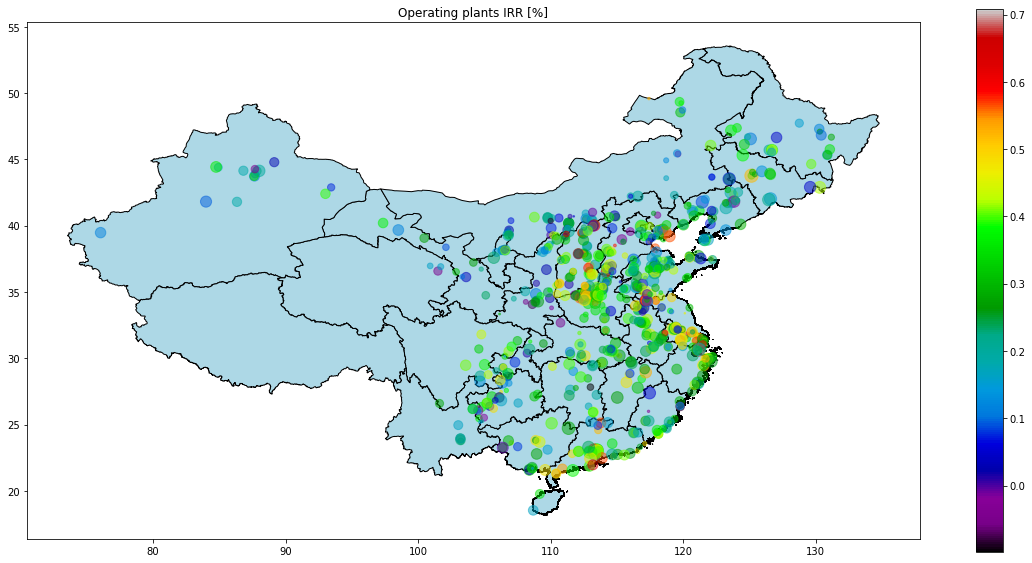

In [81]:
cmap = plt.get_cmap('nipy_spectral')
fig, ax = plt.subplots(figsize=(20,10))

china.plot(ax=ax,color='lightblue',edgecolor='k')
df.plot(ax=ax,column=f'{variable}_{scenario}', cmap=cmap, markersize=df[f'{variable}_{scenario}']*250, alpha=0.5, legend=True)
ax.set_title(f'{status.title()} plants {variable.upper()} [{units[variable]}]')

/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/matplotlib/collections.py:886: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0, 0.5, 'LCOE [Yuan/kW h]')

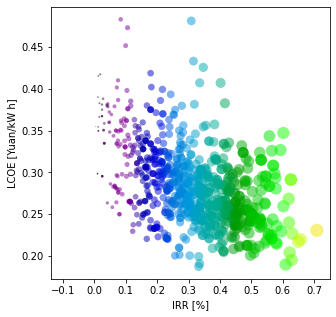

In [79]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(df[f'irr_{scenario}'], df[f'lcoe_{scenario}'], c=cmap(df[f'irr_{scenario}']), s=df[f'irr_{scenario}']*250, alpha=0.5, edgecolors='none')
ax.set_xlabel('IRR [%]')
ax.set_ylabel('LCOE [Yuan/kW h]')